In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define dataset path
dataset_path = r"C:\Users\navan\Downloads\HAND GESTURE\leapGestRecog\09"

# Initialize lists for images and labels
images, labels = [], []
label_map = {}  # Mapping folder names to labels
img_size = 128  # Resize images to 128x128

# Load images and labels
for label_id, folder in enumerate(sorted(os.listdir(dataset_path))):  
    folder_path = os.path.join(dataset_path, folder)
    
    if not os.path.isdir(folder_path):
        continue  

    label_map[folder] = label_id  
    
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)

        # Ensure it's an image file (including PNG)
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue  

        # Read image in grayscale mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Unable to read {img_path}, skipping...")
            continue  
        
        # Resize and normalize
        img = cv2.resize(img, (img_size, img_size)) / 255.0  
        images.append(img)
        labels.append(label_id)

# Convert to NumPy arrays
if len(images) == 0:
    raise ValueError("No images found! Check dataset directory structure.")

images = np.array(images).reshape(-1, img_size, img_size, 1)  
labels = np.array(labels)

# Ensure labels array is not empty before one-hot encoding
if labels.size == 0:
    raise ValueError("No valid labels found. Ensure images are correctly loaded.")

labels = to_categorical(labels)  

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print dataset summary
print(f"Total images: {len(images)}")
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")
print(f"Image shape: {X_train.shape[1:]}")

Total images: 2000
Training samples: 1280, Validation samples: 320, Test samples: 400
Image shape: (128, 128, 1)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\navan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,354 (12.61 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

C:\Users\navan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.1260 - loss: 2.2964 - val_accuracy: 0.1375 - val_loss: 2.1469
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.2237 - loss: 2.1045 - val_accuracy: 0.4812 - val_loss: 1.6896
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.3305 - loss: 1.7924 - val_accuracy: 0.6562 - val_loss: 1.3005
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.4854 - loss: 1.4176 - val_accuracy: 0.7781 - val_loss: 0.7904
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.5815 - loss: 1.1039 - val_accuracy: 0.8188 - val_loss: 0.6614
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.6794 - loss: 0.9249 - val_accuracy: 0.8938 - val_loss: 0.5141
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.6826 - loss: 0.8470 - val_accuracy: 0.8813 - val_loss: 0.4396
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.7128 - loss: 0.7244 - val_accuracy: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9359 - loss: 0.1294 
Test Accuracy: 0.9425
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step


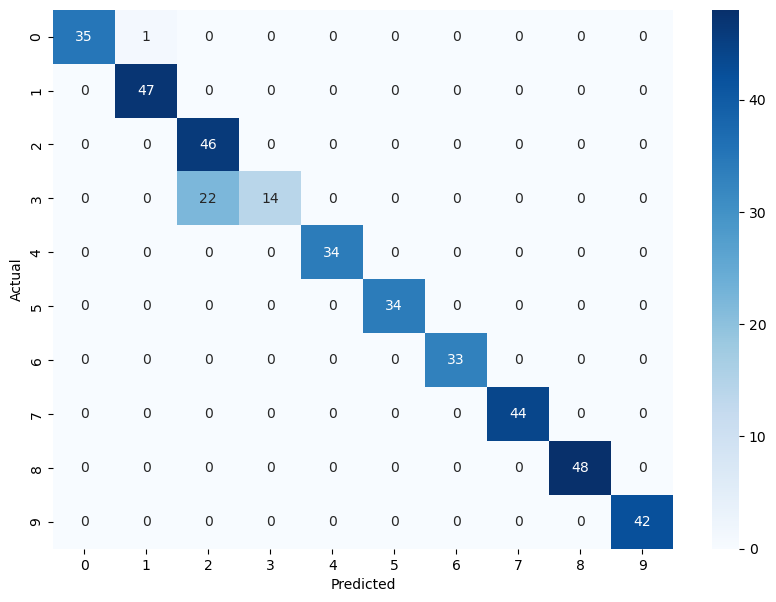

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.98      1.00      0.99        47
           2       0.68      1.00      0.81        46
           3       1.00      0.39      0.56        36
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        48
           9       1.00      1.00      1.00        42

    accuracy                           0.94       400
   macro avg       0.97      0.94      0.93       400
weighted avg       0.96      0.94      0.94       400



In [19]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
import cv2
import numpy as np

# Load trained model
model = tf.keras.models.load_model("hand_gesture_model.h5")

# Function to predict gesture
def predict_gesture(image):
    image = cv2.resize(image, (img_size, img_size)) / 255.0
    image = np.expand_dims(image, axis=[0, -1])  # Reshape for model
    prediction = model.predict(image)
    return np.argmax(prediction)

# OpenCV webcam capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gesture = predict_gesture(gray)
    
    cv2.putText(frame, f"Gesture: {gesture}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Hand Gesture Recognition", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import os

# Define model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Adjust output layer for your classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (Replace X_train, y_train with actual training data)
# model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))  

# Save the model
model.save("hand_gesture_model.h5")
print("✅ Model saved as hand_gesture_model.h5")

C:\Users\navan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model saved as hand_gesture_model.h5


In [27]:
import os
print("Found Model:", os.path.exists("hand_gesture_model.h5"))

Found Model: True


In [29]:
model = tf.keras.models.load_model("hand_gesture_model.h5")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [33]:
import os

# Set the directory where you think the file might be
search_path = r"C:\Users\navan"

# Search for the model file
for root, dirs, files in os.walk(search_path):
    if "hand_gesture_model.h5" in files:
        print("✅ Found at:", os.path.join(root, "hand_gesture_model.h5"))
        break
else:
    print("❌ File not found in", search_path)

✅ Found at: C:\Users\navan\hand_gesture_model.h5
